# Ensemble model for Time Series Forecasting

Ensemble learning is a very promising technique for time series forecasting. The purpose of ensemble learning is to combine several simple models into a single strong learner to reduce errors or improve forecasting results.

StatsForecast allows to create Ensembles models in a very easy way. First we need to import the data that we are going to use (in this case M4 Dataset). After that, we´ll to generate the forecasts via the `generate_forecast()` function. Finally, we´ll create the ensemble models using the forecasts previusly generated. In this notebook we’ll implement and benchmark a ensemble model of AutoARIMA, AutoETS and AutoCES:

+ AutoARIMA: The autoregressive integrated moving average (ARIMA), combines differencing steps, lag regression and moving averages into a single method capable of modeling non-stationary time series. This method complements on ETS and it is based on the description of data’s autocorrelations.

+ ETS: The exponential smoothing (ETS) algorithm is especially suited for data with seasonality and trend. ETS computes a weighted average over all observations in the input time series dataset as its prediction. In contrast to moving average methods with constant weights, ETS weights exponentially decrease over time, capturing long term dependencies while prioritizing new observations.

+ CES algorithm models the time series using “information potential”, modeling the non-linearity in time series using a complex-valued representation. The weights exponentially decrease over time on complex and real plains rather than the constant weights in simple moving average methods.

### Import the libraries that we are going to use for the analysis:

In [112]:
# Data Manipulation
import pandas as pd
import numpy as np
import scipy

# Plotting graphs
import matplotlib.pyplot as plt

# Statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import ETS
from statsforecast.models import AutoCES
from statsforecast.models import Naive
from neuralforecast.data.datasets.m4 import M4, M4Info

# Others
from datasetsforecast.utils import Info, async_download_files, download_file, extract_file
from datasetsforecast.losses import mase, smape
from fastcore.test import test_close
from typing import Optional, Tuple, Union
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import random
import fire
import os

from datasetsforecast.utils import Info, async_download_files, download_file, extract_file
from datasetsforecast.losses import mase, smape
from fastcore.test import test_close
from typing import Optional, Tuple, Union
from itertools import product
import warnings
warnings.filterwarnings('ignore')

### Loading and Exploring the M4 Dataset

The M4 dataset is a collection of 100,000 time series used for the fourth edition of the Makridakis forecasting Competition. The M4 dataset consists of time series of yearly, quarterly, monthly and other (weekly, daily and hourly) data, which are divided into training and test sets. The minimum numbers of observations in the training test are 13 for yearly, 16 for quarterly, 42 for monthly, 80 for weekly, 93 for daily and 700 for hourly series. The participants were asked to produce the following numbers of forecasts beyond the available data that they had been given: six for yearly, eight for quarterly, 18 for monthly series, 13 for weekly series and 14 and 48 forecasts respectively for the daily and hourly ones.

The M4 dataset was created by selecting a random sample of 100,000 time series from the ForeDeCk database. The selected series were then scaled to prevent negative observations and values lower than 10, thus avoiding possible problems when calculating various error measures. The scaling was performed by simply adding a constant to the series so that their minimum value was equal to 10 (29 occurrences across the whole dataset). In addition, any information that could possibly lead to the identification of the original series was removed so as to ensure the objectivity of the results. This included the starting dates of the series, which did not become available to the participants until the M4 had ended.

In [26]:
# Create a dictionary with the data:
dict_datasets = {'M4': (M4, M4Info)}

In [28]:
def generate_forecast(directory: str, dataset, group):

    '''generate_forecast() function: Return a dataframe with AutoARIMA, ETS and CES forecasts for the group required.

    * df_forecast: 'data'
    * dataset: 'M4'
    * group: Refeers to the M4 group (Hourly, Daily, Weekly, Monthly, Quarterly or Yearly)'''

    dataclass, datainfo = dict_datasets[dataset]
    Y_df_group, *_ = dataclass.load(directory, group)
    
    ids = list(Y_df_group['unique_id'].unique())
    Y_df = Y_df_group.query('unique_id in @ids')
    Y_df["unique_id"] = Y_df["unique_id"].astype(str)

    # Set the forecast horizon and frecuency:
    horizon = datainfo[group].horizon
    freq = datainfo[group].freq
    seasonality = datainfo[group].seasonality

    # Split data in train and test series:
    Y_df_test = Y_df.groupby('unique_id').tail(horizon)
    Y_train_df = Y_df.drop(Y_df_test.index)

    # Define the models that are going to compose the ensemble:
    models = [AutoARIMA(season_length=seasonality, approximation=True),
              ETS(season_length=seasonality, model='ZZA'), 
              AutoCES(season_length=seasonality)]

    # Create the forecast object and forecast test set:
    model = StatsForecast(df=Y_train_df, models=models, freq=freq, n_jobs=-1, fallback_model= Naive())
    Y_hat_df = model.forecast(horizon).reset_index()


    Y_test_df = Y_df_test.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

    return Y_test_df

In [93]:
def get_train_df(group: str):

    '''get_train_df() function: Return a dataframe with train values for the group required.

    * group: Refeers to the M4 group (Hourly, Daily, Weekly, Monthly, Quarterly or Yearly)'''

    dataclass, datainfo = dict_datasets['M4']
    Y_df_total, *_ = dataclass.load('data2', group)
    seasonality = datainfo[group].seasonality
    Y_train_df = Y_df_total.drop(Y_df_total.groupby('unique_id').tail(seasonality).index)
    
    return Y_train_df

In [85]:
# Plot functions:
def plot_grid(df_train, model_cols=["y_50"], df_test=None, plot_random=True):
    """Plots multiple time series."""
    fig, axes = plt.subplots(4, 2, figsize = (24, 14))

    unique_ids = df_train['unique_id'].unique()

    assert len(unique_ids) >= 8, "Must provide at least 8 ts"
    
    if plot_random:
        unique_ids = random.sample(list(unique_ids), k=8)
    else:
        unique_uids = unique_ids[:8]

    for uid, (idx, idy) in zip(unique_ids, product(range(4), range(2))):
        train_uid = df_train.query('unique_id == @uid')
        axes[idx, idy].plot(train_uid['ds'], train_uid['y'], label = 'y_train', c='black')
        axes[idx, idy].xaxis.set_tick_params(rotation=45)
        if df_test is not None:
            max_ds = train_uid['ds'].max()
            test_uid = df_test.query('unique_id == @uid')
            axes[idx, idy].plot(test_uid['ds'], test_uid['y'], c='black', label='True')

            for col in model_cols:
                axes[idx, idy].plot(test_uid['ds'], test_uid[col], label=col)

        axes[idx, idy].set_title(f'State: {uid}')
        axes[idx, idy].set_xlabel('Timestamp [t]')
        axes[idx, idy].set_ylabel('Target')
        axes[idx, idy].legend(loc='upper left')
        axes[idx, idy].xaxis.set_major_locator(plt.MaxNLocator(20))
        axes[idx, idy].grid()
    fig.subplots_adjust(hspace=0.7)
    plt.show()

In [32]:
#| export
class M4Evaluation:
    
    @staticmethod
    def load_benchmark(directory: str, group: str,
                       source_url: Optional[str] = None) -> np.ndarray:
        """Downloads and loads a bechmark forecasts.
        
        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'Yearly', 'Quarterly', 'Monthly', 
                            'Weekly', 'Daily', 'Hourly'.
        source_url: str, optional
            Optional benchmark url obtained from 
            https://github.com/Nixtla/m4-forecasts/tree/master/forecasts.
            If `None` returns Naive2. 
        
        Returns
        -------
        benchmark: numpy array
            Numpy array of shape (n_series, horizon).
        """
        path = f'{directory}/m4/datasets'
        initial = group[0]
        if source_url is not None:
            filename = source_url.split('/')[-1].replace('.rar', '.csv')
            filepath = f'{path}/{filename}'
            if not os.path.exists(filepath):
                download_file(path, source_url, decompress=True)
        else:
            filepath = f'{path}/submission-Naive2.csv'
        
        benchmark = pd.read_csv(filepath)
        benchmark = benchmark[benchmark['id'].str.startswith(initial)]
        benchmark = benchmark.set_index('id').dropna(axis=1)
        benchmark = benchmark.sort_values('id').values
        
        return benchmark
    
    @staticmethod
    def evaluate(directory: str, group: str, 
                 y_hat: Union[np.ndarray, str]) -> pd.DataFrame:
        """Evaluates y_hat according to M4 methodology.
        
        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'Yearly', 'Quarterly', 'Monthly', 
                            'Weekly', 'Daily', 'Hourly'.
        y_hat: numpy array, str
            Group forecasts as numpy array or
            benchmark url from
            https://github.com/Nixtla/m4-forecasts/tree/master/forecasts.
            
        Returns
        -------
        evaluation: pandas dataframe
            DataFrame with columns OWA, SMAPE, MASE
            and group as index.
        """

        if isinstance(y_hat, str):
            y_hat = M4Evaluation.load_benchmark(directory, group, y_hat)
        
        initial = group[0]
        class_group = M4Info[group]
        horizon = class_group.horizon
        seasonality = class_group.seasonality
        path = f'{directory}/m4/datasets'
        y_df, *_ = M4.load(directory, group)
        
        y_train = y_df.groupby('unique_id')['y'] 
        y_train = y_train.apply(lambda x: x.head(-horizon).values)
        y_train = y_train.values
        
        y_test = y_df.groupby('unique_id')['y']
        y_test = y_test.tail(horizon)
        y_test = y_test.values.reshape(-1, horizon)    

        naive2 = M4Evaluation.load_benchmark(directory, group)
        smape_y_hat = smape(y_test, y_hat)
        smape_naive2 = smape(y_test, naive2)
        
        mase_y_hat = np.mean([mase(y_test[i], y_hat[i], y_train[i], seasonality)
                              for i in range(class_group.n_ts)])
        mase_naive2 = np.mean([mase(y_test[i], naive2[i], y_train[i], seasonality)
                               for i in range(class_group.n_ts)])
        
        owa = .5 * (mase_y_hat / mase_naive2 + smape_y_hat / smape_naive2)
        
        evaluation = pd.DataFrame({'SMAPE': smape_y_hat,
                                   'MASE': mase_y_hat,
                                   'OWA': owa},
                                   index=[group])
        
        return evaluation

### Hourly time series forecast:

In [80]:
# Create forecasts:
hourly_df_forecast = generate_forecast('data', 'M4', 'Hourly')

In [36]:
# Create Ensemble models:
hourly_df_forecast['Ensemble_mean'] = (hourly_df_forecast.AutoARIMA + hourly_df_forecast.ETS + hourly_df_forecast.CES) / 3
hourly_df_forecast['Ensemble_median'] = hourly_df_forecast[['AutoARIMA', 'ETS', 'CES']].median(axis=1)

# Export Pandas DataFrame to CSV:
hourly_df_forecast.to_csv('hourly_df_forecast.csv')

# Print dataframe:
hourly_df_forecast

,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,0,H1,701,619.0,616.08417,631.88960,621.20000,623.057923,621.20000
1,1,H1,702,565.0,544.43210,559.75085,556.26890,553.483950,556.26890
2,2,H1,703,532.0,510.41450,519.23550,512.23285,513.960950,512.23285
3,3,H1,704,495.0,481.04654,486.97336,479.32480,482.448233,481.04654
4,4,H1,705,481.0,460.89307,464.69736,457.91028,461.166903,460.89307
...,...,...,...,...,...,...,...,...,...
19867,19867,H99,744,24039.0,26955.49600,26916.31000,26628.86700,26833.557667,26916.31000
19868,19868,H99,745,22946.0,25947.76600,26036.80700,25965.55000,25983.374333,25965.55000
19869,19869,H99,746,22217.0,25043.93000,25449.20000,25611.03500,25368.055000,25449.20000
19870,19870,H99,747,21416.0,24461.45000,24974.53000,25202.98600,24879.655333,24974.53000


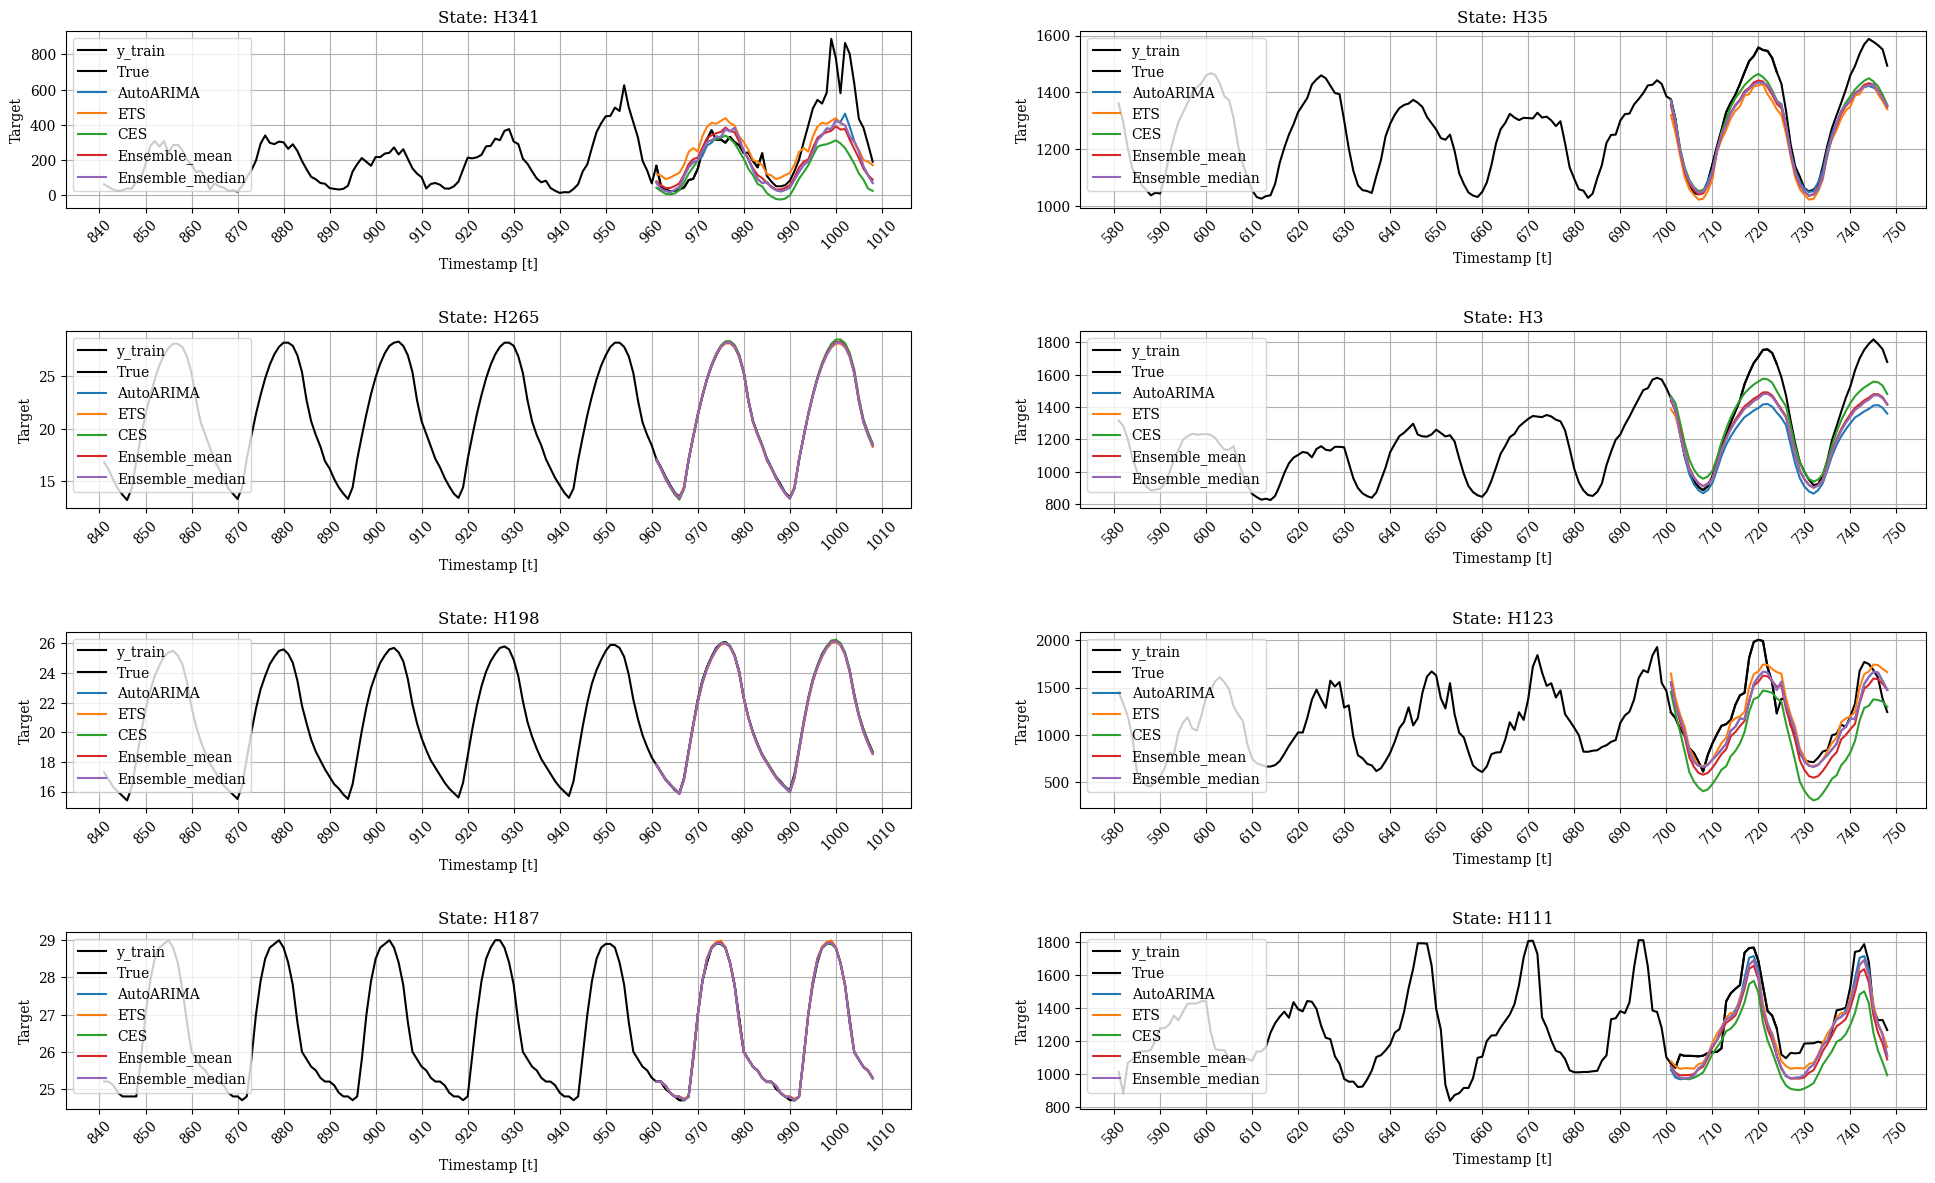

In [95]:
# Get trarin dataframe:
df_train_hourly = get_train_df('Hourly')

# Plot a random sample of 8 series
plot_grid(df_train_hourly.groupby('unique_id').tail(3*48),
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=hourly_df_forecast)

In [124]:
#Evaluate models metrics:
df_fore_hformat_hourly = pd.read_csv('hourly_df_forecast.csv')

df_fore_hformat_hourly = df_fore_hformat_hourly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_hourly['ds'] = df_fore_hformat_hourly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_hourly: np.arange(1, len(df_fore_hformat_hourly) + 1))
df_fore_hformat_hourly = pd.melt(df_fore_hformat_hourly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_hourly = pd.pivot(df_fore_hformat_hourly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_hourly['model'] == 'Ensemble_median'
df_fore_hformat_hourly_ens = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_ens = df_fore_hformat_hourly_ens.set_index(df_fore_hformat_hourly_ens['id'])
df_fore_hformat_hourly_ens = df_fore_hformat_hourly_ens.drop(['id', 'model'], axis=1)

h_metrics_ens = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_ens.sort_values('id').values)

#AutoARIMA:
df_mask=df_fore_hformat_hourly['model'] == 'AutoARIMA'
df_fore_hformat_hourly_AutoARIMA = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_AutoARIMA = df_fore_hformat_hourly_AutoARIMA.set_index(df_fore_hformat_hourly_AutoARIMA['id'])
df_fore_hformat_hourly_AutoARIMA = df_fore_hformat_hourly_AutoARIMA.drop(['id', 'model'], axis=1)

h_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_AutoARIMA.sort_values('id').values)

#ETS:
df_mask=df_fore_hformat_hourly['model'] == 'ETS'
df_fore_hformat_hourly_ETS = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_ETS = df_fore_hformat_hourly_ETS.set_index(df_fore_hformat_hourly_ETS['id'])
df_fore_hformat_hourly_ETS = df_fore_hformat_hourly_ETS.drop(['id', 'model'], axis=1)

h_metrics_ETS = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_ETS.sort_values('id').values)

#CES:
df_mask=df_fore_hformat_hourly['model'] == 'CES'
df_fore_hformat_hourly_CES = df_fore_hformat_hourly[df_mask]

df_fore_hformat_hourly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_hourly_CES = df_fore_hformat_hourly_CES.set_index(df_fore_hformat_hourly_CES['id'])
df_fore_hformat_hourly_CES = df_fore_hformat_hourly_CES.drop(['id', 'model'], axis=1)

h_metrics_CES = M4Evaluation.evaluate('data2', 'Hourly', df_fore_hformat_hourly_CES.sort_values('id').values)

# Total metrics:
metrics_hourly = [h_metrics_ens, h_metrics_AutoARIMA, h_metrics_ETS, h_metrics_CES]  # List of dataframes
total_metrics_hourly = pd.concat(metrics_hourly)
total_metrics_hourly['model'] = ['Ensemble','AutoARIMA', 'ETS', 'CES']
total_metrics_hourly

,SMAPE,MASE,OWA,model
Hourly,13.745924,0.957705,0.573814,Ensemble
Hourly,13.785071,1.060768,0.596394,AutoARIMA
Hourly,14.757317,1.065372,0.623800,ETS
Hourly,19.689685,1.183220,0.782559,CES


### Daily time series forecast:


In [106]:
# Create forecasts:
daily_df_forecast = generate_forecast('data', 'M4', 'Daily')

In [63]:
# Create Ensemble models:
daily_df_forecast['Ensemble_mean'] = (daily_df_forecast.AutoARIMA + daily_df_forecast.ETS + daily_df_forecast.CES) / 3
daily_df_forecast['Ensemble_median'] = daily_df_forecast[['AutoARIMA', 'ETS', 'CES']].median(axis=1)

# Export Pandas DataFrame to CSV:
daily_df_forecast.to_csv('daily_df_forecast.csv')

# Print dataframe:
daily_df_forecast

,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,0,D1,1007,2039.20,2029.7000,2030.0854,2031.1837,2030.323033,2030.0854
1,1,D1,1008,2035.00,2029.7000,2030.4905,2031.4049,2030.531800,2030.4905
2,2,D1,1009,2051.80,2029.7000,2031.5201,2033.0112,2031.410433,2031.5201
3,3,D1,1010,2061.80,2029.7000,2031.3804,2034.0948,2031.725067,2031.3804
4,4,D1,1011,2063.50,2029.7000,2031.5995,2035.7246,2032.341367,2031.5995
...,...,...,...,...,...,...,...,...,...
59173,59173,D999,1062,1262.08,1245.3746,1241.5011,1245.2219,1244.032533,1245.2219
59174,59174,D999,1063,1262.78,1245.3746,1243.5731,1247.0388,1245.328833,1245.3746
59175,59175,D999,1064,1264.66,1245.3746,1241.3363,1245.2800,1243.996967,1245.2800
59176,59176,D999,1065,1272.66,1245.3746,1244.5017,1248.6119,1246.162733,1245.3746


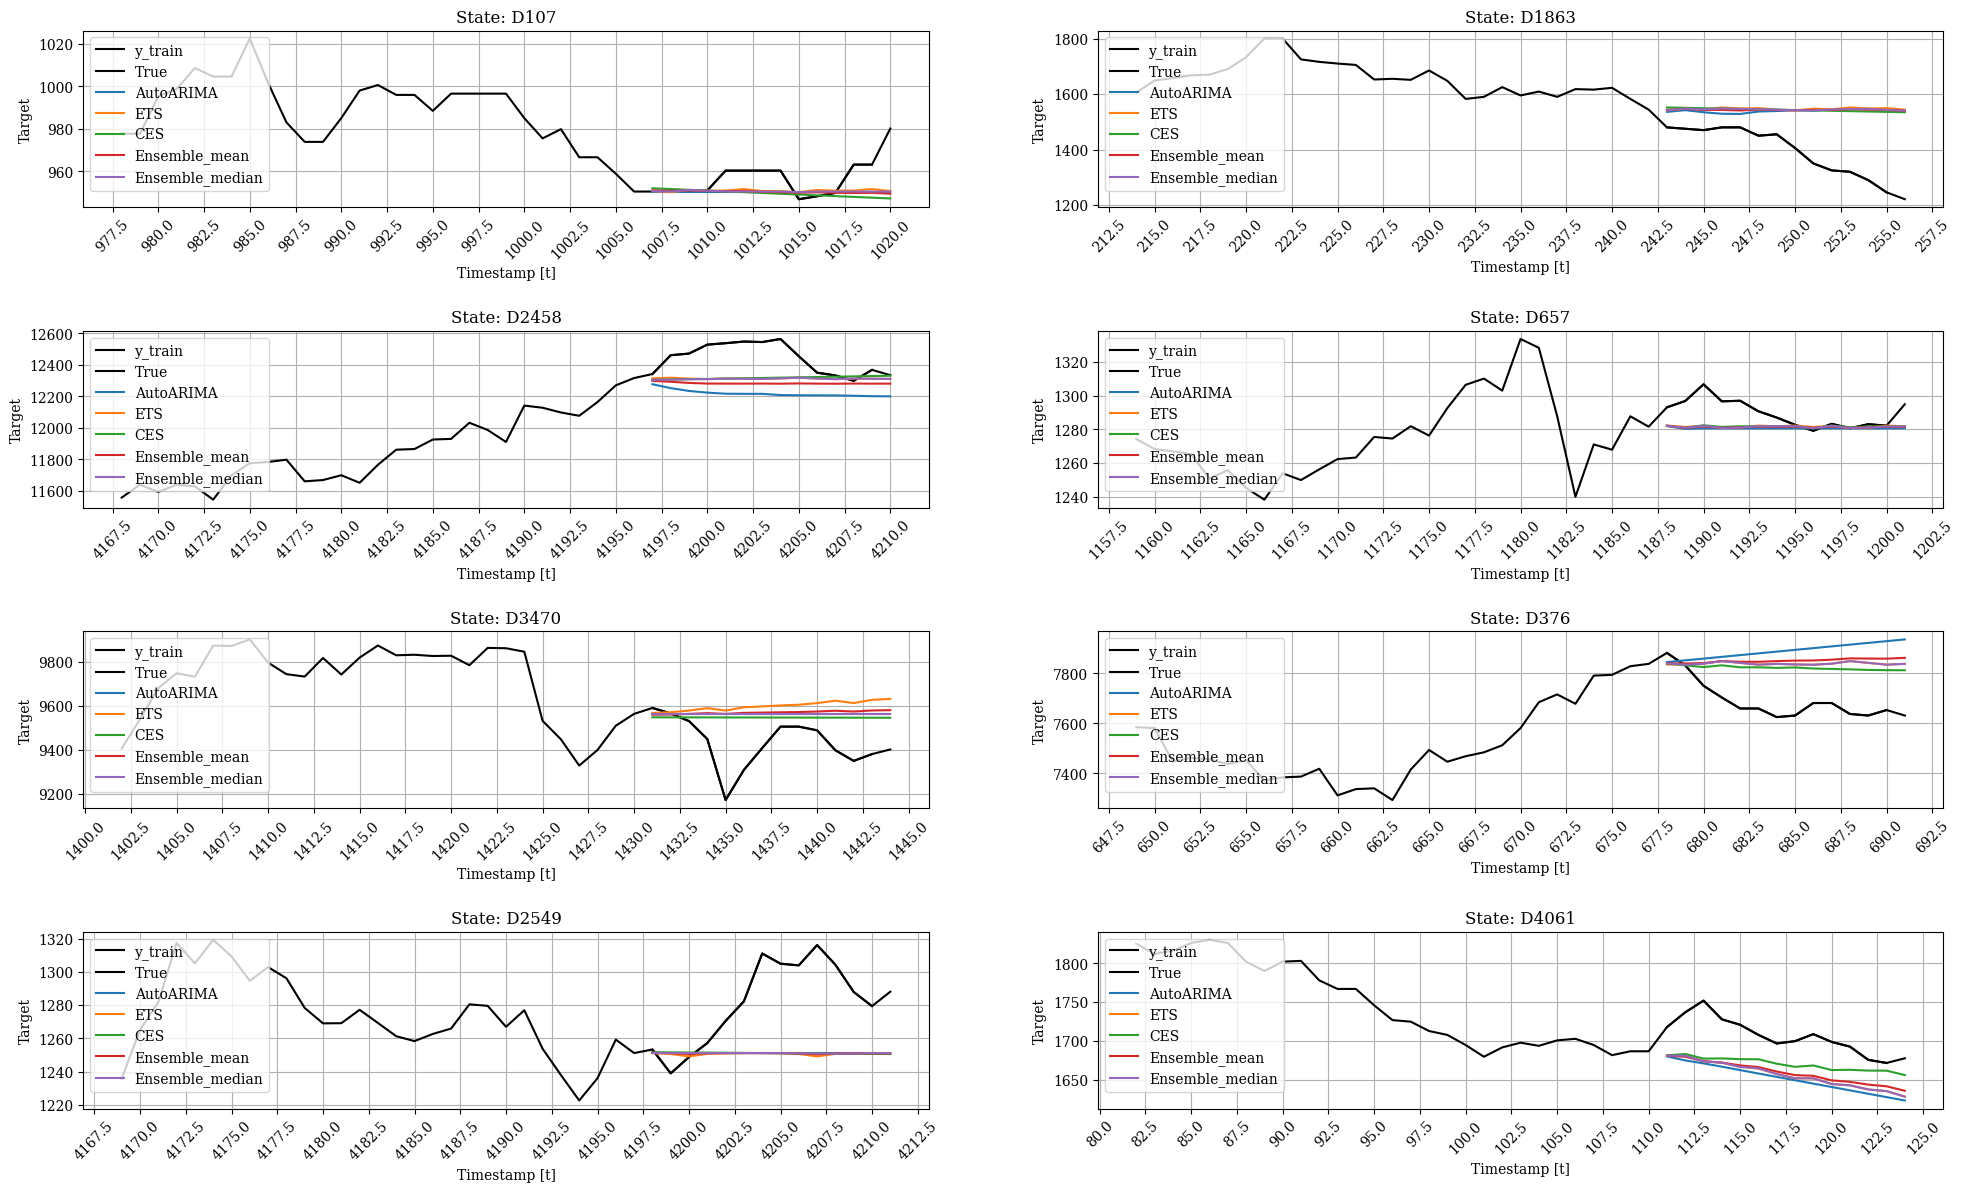

In [96]:
# Get trarin dataframe:
df_train_daily = get_train_df('Daily')

# Plot a random sample of 8 series:
plot_grid(df_train_daily.groupby('unique_id').tail(3*14), 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=daily_df_forecast)

In [125]:
#Evaluate models metrics:
df_fore_hformat_daily = pd.read_csv('daily_df_forecast.csv')

df_fore_hformat_daily = df_fore_hformat_daily.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_daily['ds'] = df_fore_hformat_daily.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_daily: np.arange(1, len(df_fore_hformat_daily) + 1))
df_fore_hformat_daily = pd.melt(df_fore_hformat_daily, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_daily = pd.pivot(df_fore_hformat_daily, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_daily['model'] == 'Ensemble_median'
df_fore_hformat_daily_ens = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_ens = df_fore_hformat_daily_ens.set_index(df_fore_hformat_daily_ens['id'])
df_fore_hformat_daily_ens = df_fore_hformat_daily_ens.drop(['id', 'model'], axis=1)

d_metrics_ens = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_daily['model'] == 'AutoARIMA'
df_fore_hformat_daily_AutoARIMA = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_AutoARIMA = df_fore_hformat_daily_AutoARIMA.set_index(df_fore_hformat_daily_AutoARIMA['id'])
df_fore_hformat_daily_AutoARIMA = df_fore_hformat_daily_AutoARIMA.drop(['id', 'model'], axis=1)

d_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_daily['model'] == 'ETS'
df_fore_hformat_daily_ETS = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_ETS = df_fore_hformat_daily_ETS.set_index(df_fore_hformat_daily_ETS['id'])
df_fore_hformat_daily_ETS = df_fore_hformat_daily_ETS.drop(['id', 'model'], axis=1)

d_metrics_ETS = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_daily['model'] == 'CES'
df_fore_hformat_daily_CES = df_fore_hformat_daily[df_mask]

df_fore_hformat_daily_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_daily_CES = df_fore_hformat_daily_CES.set_index(df_fore_hformat_daily_CES['id'])
df_fore_hformat_daily_CES = df_fore_hformat_daily_CES.drop(['id', 'model'], axis=1)

d_metrics_CES = M4Evaluation.evaluate('data2', 'Daily', df_fore_hformat_daily_CES.sort_values('id').values)

# Total metrics:
metrics_daily = [d_metrics_ens, d_metrics_AutoARIMA, d_metrics_ETS, d_metrics_CES]  # List of dataframes
total_metrics_daily = pd.concat(metrics_daily)
total_metrics_daily['model'] = ['Ensemble','AutoARIMA', 'ETS', 'CES']
total_metrics_daily

,SMAPE,MASE,OWA,model
Daily,3.060829,3.266275,1.000705,Ensemble
Daily,3.147886,3.313655,1.022225,AutoARIMA
Daily,3.061928,3.291211,1.004688,ETS
Daily,3.129341,3.320487,1.020222,CES


### Weekly time series forecast:

In [111]:
# Create forecasts:
weekly_df_forecast = generate_forecast('data', 'M4', 'Weekly')

In [72]:
# Create Ensemble models:
weekly_df_forecast['Ensemble_mean'] = (weekly_df_forecast.AutoARIMA + weekly_df_forecast.ETS + weekly_df_forecast.CES) / 3
weekly_df_forecast['Ensemble_median'] = weekly_df_forecast[['AutoARIMA', 'ETS', 'CES']].median(axis=1)

# Export Pandas DataFrame to CSV:
weekly_df_forecast.to_csv('weekly_df_forecast.csv')

# Print dataframe:
weekly_df_forecast

,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,0,W1,2180,35397.16,35342.890,35397.16,35612.797,35450.949000,35397.160
1,1,W1,2181,35808.59,34388.465,35397.16,35618.130,35134.585000,35397.160
2,2,W1,2182,35808.59,33750.640,35397.16,35617.050,34921.616667,35397.160
3,3,W1,2183,36246.14,33101.777,35397.16,35692.060,34730.332333,35397.160
4,4,W1,2184,36246.14,32489.988,35397.16,35727.113,34538.087000,35397.160
...,...,...,...,...,...,...,...,...,...
4662,4662,W99,2292,14864.72,15505.123,15101.03,15165.904,15257.352333,15165.904
4663,4663,W99,2293,14893.35,15499.500,15101.03,15163.030,15254.520000,15163.030
4664,4664,W99,2294,14811.60,15472.848,15101.03,15158.266,15244.048000,15158.266
4665,4665,W99,2295,14898.23,15484.617,15101.03,15195.575,15260.407333,15195.575


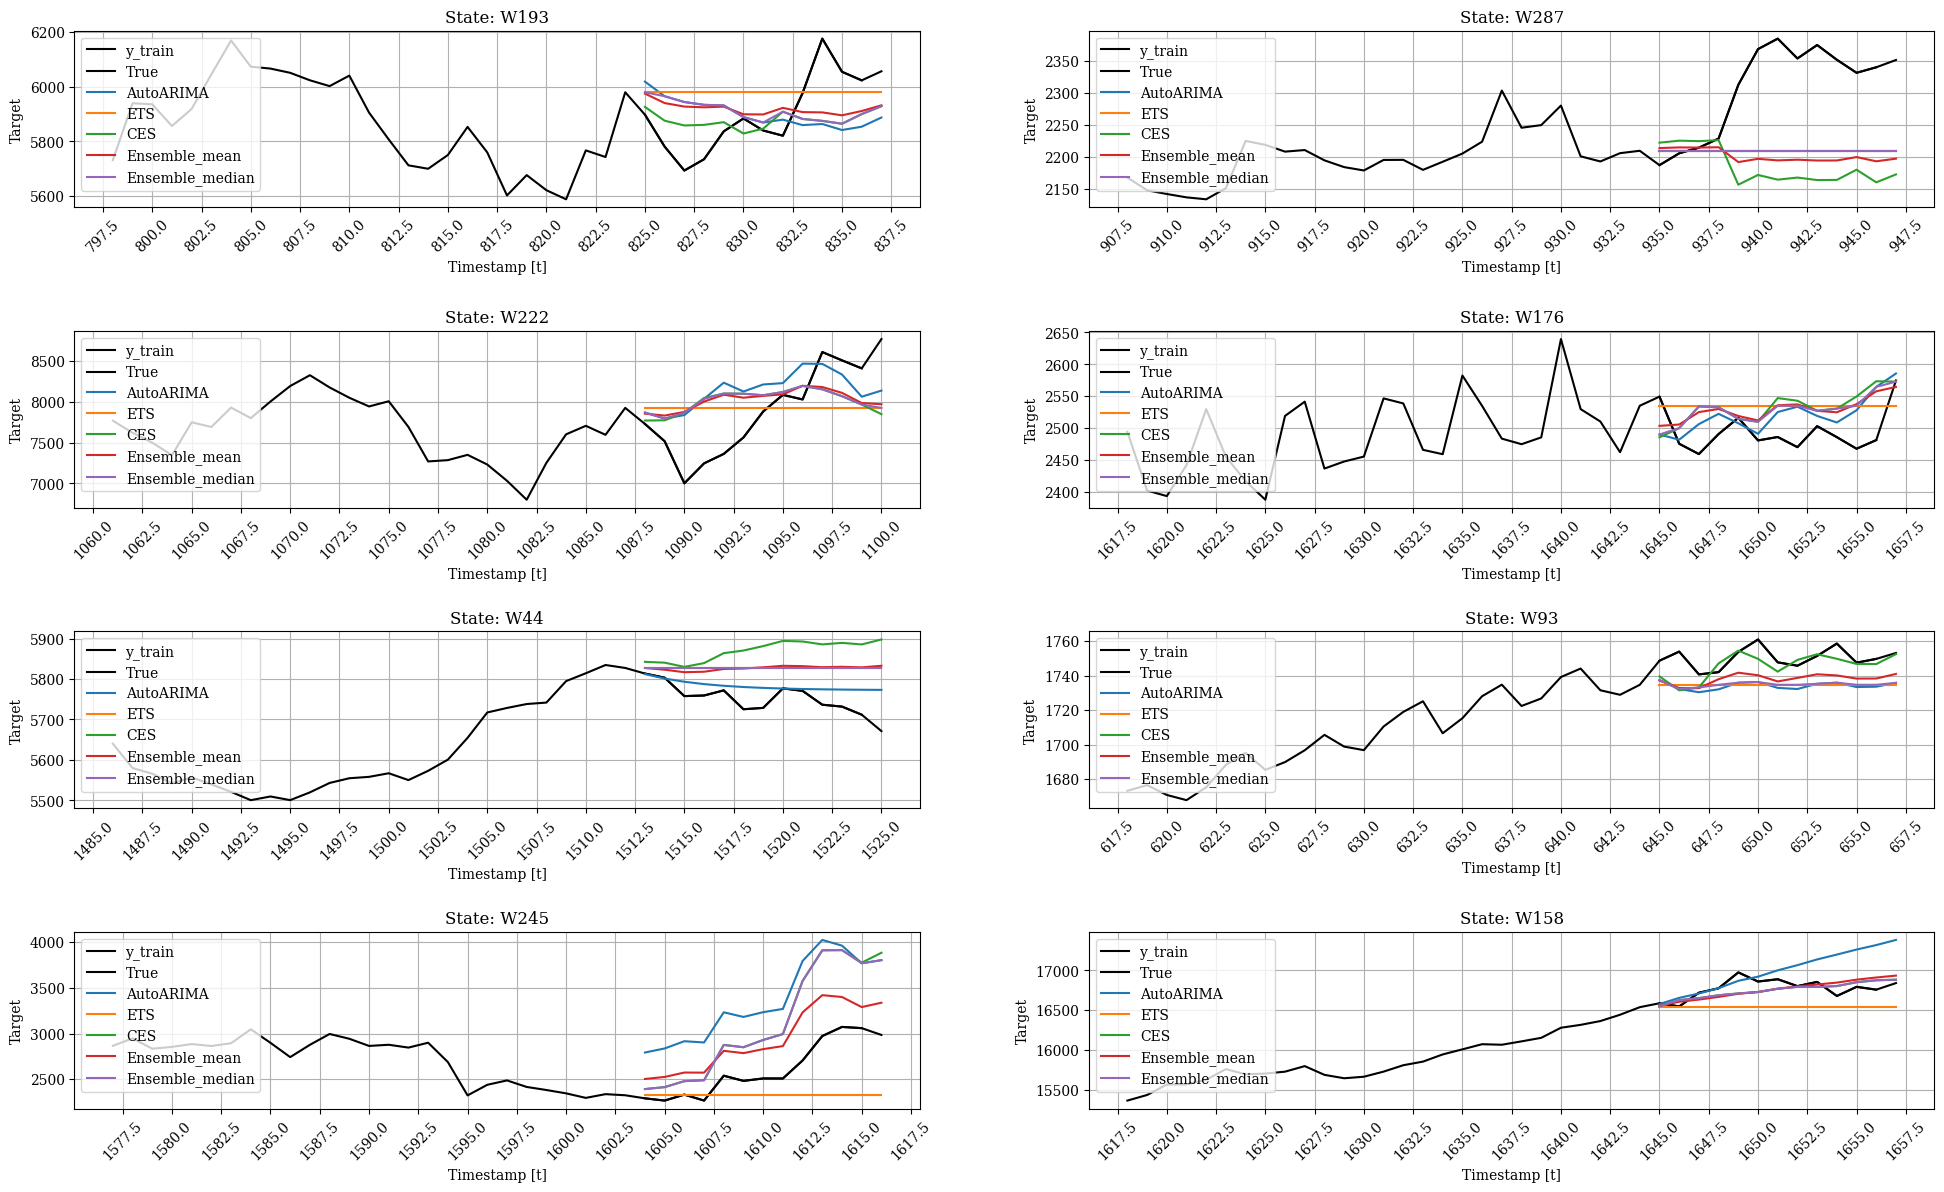

In [98]:
# Get trarin dataframe:
df_train_weekly = get_train_df('Weekly')

# Plot a random sample of 8 series:
plot_grid(df_train_weekly.groupby('unique_id').tail(3*13),
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=weekly_df_forecast)

In [126]:
#Evaluate models metrics:
df_fore_hformat_weekly = pd.read_csv('weekly_df_forecast.csv')

df_fore_hformat_weekly = df_fore_hformat_weekly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_weekly['ds'] = df_fore_hformat_weekly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_weekly: np.arange(1, len(df_fore_hformat_weekly) + 1))
df_fore_hformat_weekly = pd.melt(df_fore_hformat_weekly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_weekly = pd.pivot(df_fore_hformat_weekly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_weekly['model'] == 'Ensemble_median'
df_fore_hformat_weekly_ens = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_ens = df_fore_hformat_weekly_ens.set_index(df_fore_hformat_weekly_ens['id'])
df_fore_hformat_weekly_ens = df_fore_hformat_weekly_ens.drop(['id', 'model'], axis=1)

w_metrics_ens = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_weekly['model'] == 'AutoARIMA'
df_fore_hformat_weekly_AutoARIMA = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_AutoARIMA = df_fore_hformat_weekly_AutoARIMA.set_index(df_fore_hformat_weekly_AutoARIMA['id'])
df_fore_hformat_weekly_AutoARIMA = df_fore_hformat_weekly_AutoARIMA.drop(['id', 'model'], axis=1)

w_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_weekly['model'] == 'ETS'
df_fore_hformat_weekly_ETS = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_ETS = df_fore_hformat_weekly_ETS.set_index(df_fore_hformat_weekly_ETS['id'])
df_fore_hformat_weekly_ETS = df_fore_hformat_weekly_ETS.drop(['id', 'model'], axis=1)

w_metrics_ETS = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_weekly['model'] == 'CES'
df_fore_hformat_weekly_CES = df_fore_hformat_weekly[df_mask]

df_fore_hformat_weekly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_weekly_CES = df_fore_hformat_weekly_CES.set_index(df_fore_hformat_weekly_CES['id'])
df_fore_hformat_weekly_CES = df_fore_hformat_weekly_CES.drop(['id', 'model'], axis=1)

w_metrics_CES = M4Evaluation.evaluate('data2', 'Weekly', df_fore_hformat_weekly_CES.sort_values('id').values)

# Total metrics:
metrics_weekly = [w_metrics_ens, w_metrics_AutoARIMA, w_metrics_ETS, w_metrics_CES]  # List of dataframes
total_metrics_weekly = pd.concat(metrics_weekly)
total_metrics_weekly['model'] = ['Ensemble', 'AutoARIMA', 'ETS', 'CES']
total_metrics_weekly

,SMAPE,MASE,OWA,model
Weekly,7.002584,2.192095,0.776829,Ensemble
Weekly,7.918108,2.674030,0.913559,AutoARIMA
Weekly,9.161287,2.777295,1.000000,ETS
Weekly,8.116045,2.352535,0.866483,CES


### Monthly time series forecast:

In [ ]:
# Create forecasts:
monthly_df_forecast = generate_forecast('data', 'M4', 'Monthly')

In [74]:
# Create Ensemble models:
monthly_df_forecast['Ensemble_mean'] = (monthly_df_forecast.AutoARIMA + monthly_df_forecast.ETS + monthly_df_forecast.CES) / 3
monthly_df_forecast['Ensemble_median'] = monthly_df_forecast[['AutoARIMA', 'ETS', 'CES']].median(axis=1)

# Export Pandas DataFrame to CSV:
monthly_df_forecast.to_csv('monthly_df_forecast.csv')

# Print dataframe:
monthly_df_forecast

,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,0,M1,470,8720.0,8951.7180,8408.3940,8511.9530,8624.021667,8511.9530
1,1,M1,471,7790.0,8672.3420,7553.3975,7647.7183,7957.819267,7647.7183
2,2,M1,472,4770.0,7298.8193,5874.9023,5973.6800,6382.467200,5973.6800
3,3,M1,473,5060.0,6906.7100,5539.8403,5628.4700,6025.006767,5628.4700
4,4,M1,474,4720.0,6446.5176,5032.9220,5007.5960,5495.678533,5032.9220
...,...,...,...,...,...,...,...,...,...
863995,863995,M9999,83,4200.0,3373.4060,4047.2908,2832.2737,3417.656833,3373.4060
863996,863996,M9999,84,4300.0,3367.4640,3774.5876,2754.7410,3298.930867,3367.4640
863997,863997,M9999,85,3800.0,3353.3690,3109.6357,2272.4970,2911.833900,3109.6357
863998,863998,M9999,86,4400.0,3357.4648,3268.4200,2580.5386,3068.807800,3268.4200


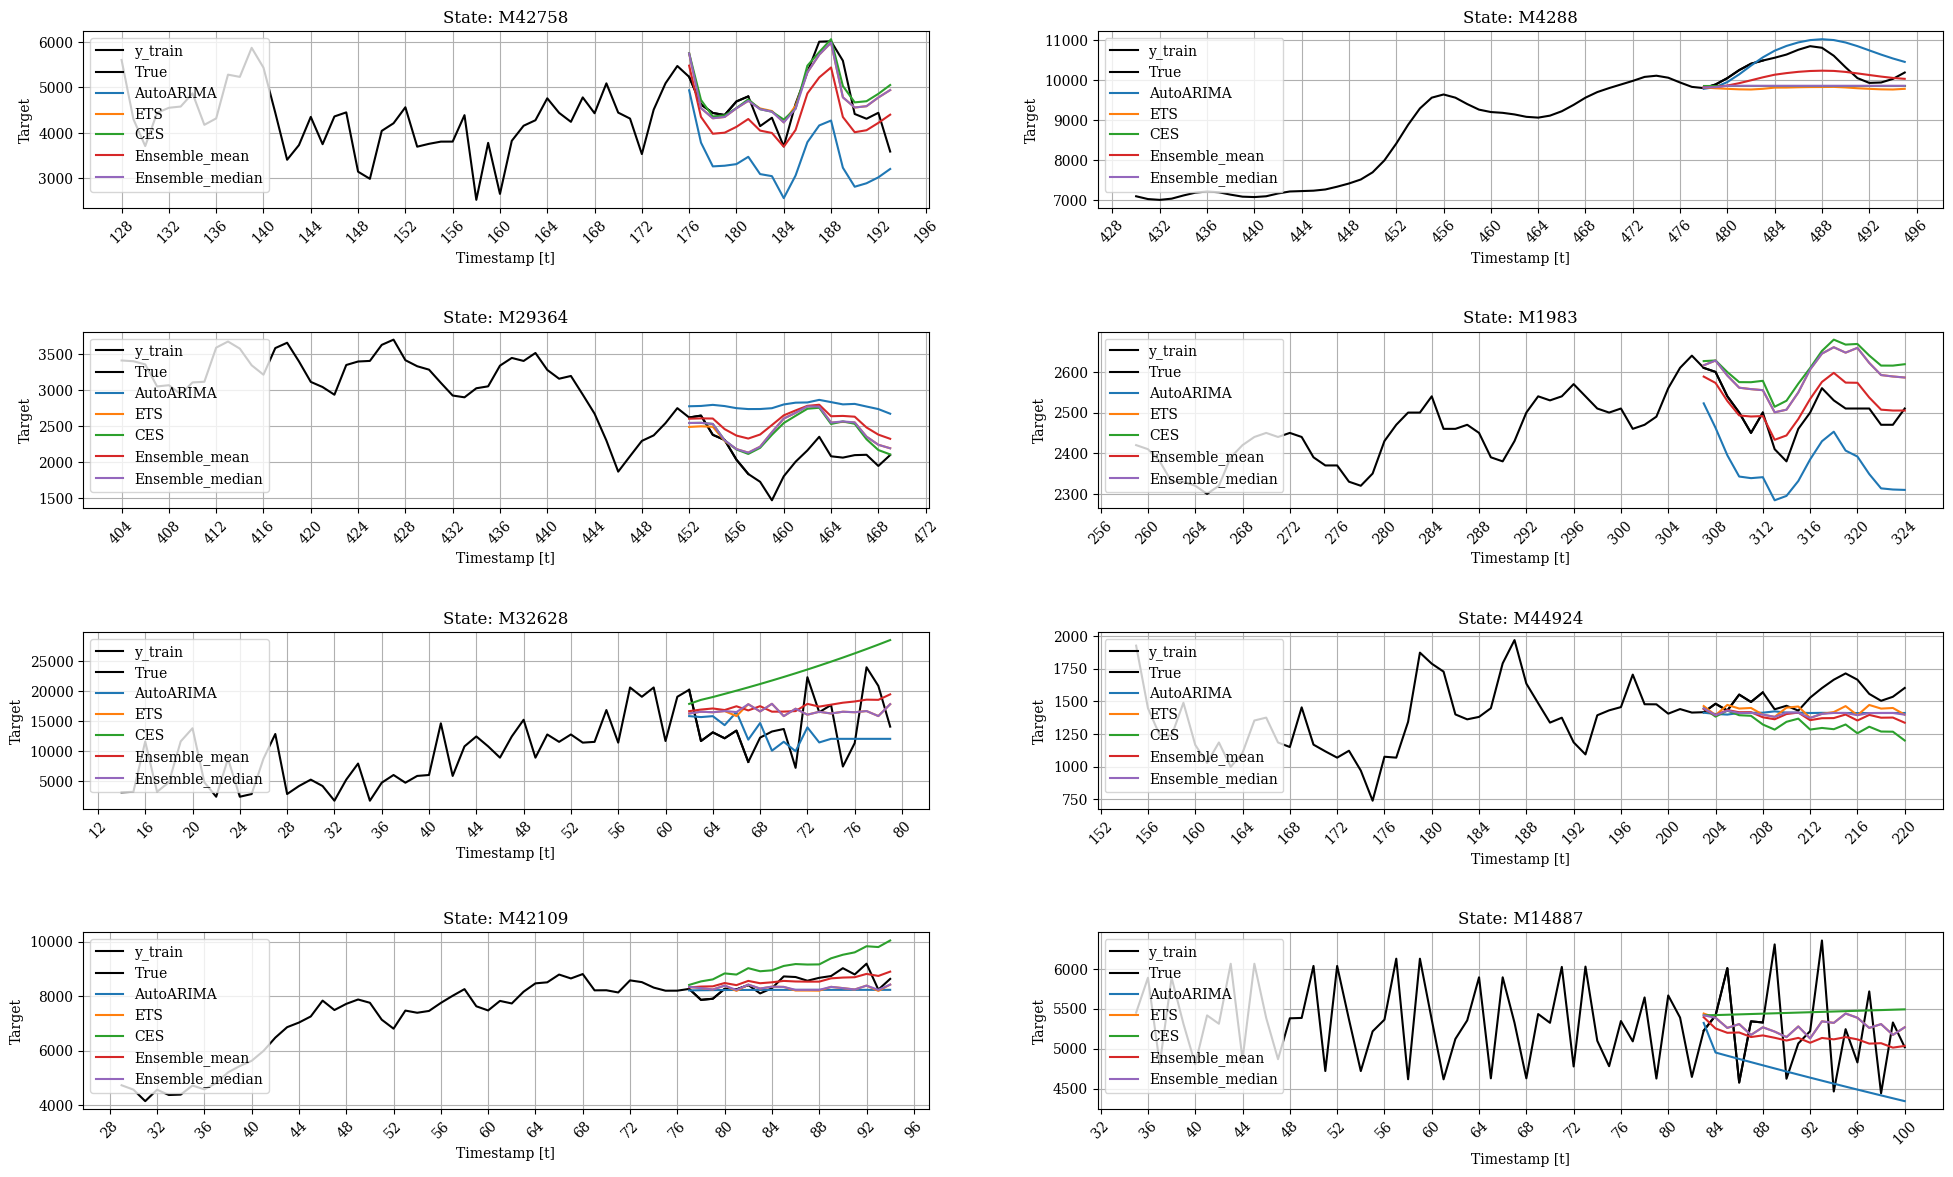

In [99]:
# Get trarin dataframe:
df_train_monthly = get_train_df('Monthly')

# Plot a random sample of 8 series:
plot_grid(df_train_monthly.groupby('unique_id').tail(3*18),
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=monthly_df_forecast)

In [127]:
#Evaluate models metrics:
df_fore_hformat_monthly = pd.read_csv('monthly_df_forecast.csv')

df_fore_hformat_monthly = df_fore_hformat_monthly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_monthly['ds'] = df_fore_hformat_monthly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_monthly: np.arange(1, len(df_fore_hformat_monthly) + 1))
df_fore_hformat_monthly = pd.melt(df_fore_hformat_monthly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_monthly = pd.pivot(df_fore_hformat_monthly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_monthly['model'] == 'Ensemble_median'
df_fore_hformat_monthly_ens = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_ens = df_fore_hformat_monthly_ens.set_index(df_fore_hformat_monthly_ens['id'])
df_fore_hformat_monthly_ens = df_fore_hformat_monthly_ens.drop(['id', 'model'], axis=1)

m_metrics_ens = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_monthly['model'] == 'AutoARIMA'
df_fore_hformat_monthly_AutoARIMA = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_AutoARIMA = df_fore_hformat_monthly_AutoARIMA.set_index(df_fore_hformat_monthly_AutoARIMA['id'])
df_fore_hformat_monthly_AutoARIMA = df_fore_hformat_monthly_AutoARIMA.drop(['id', 'model'], axis=1)

m_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_monthly['model'] == 'ETS'
df_fore_hformat_monthly_ETS = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_ETS = df_fore_hformat_monthly_ETS.set_index(df_fore_hformat_monthly_ETS['id'])
df_fore_hformat_monthly_ETS = df_fore_hformat_monthly_ETS.drop(['id', 'model'], axis=1)

m_metrics_ETS = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_monthly['model'] == 'CES'
df_fore_hformat_monthly_CES = df_fore_hformat_monthly[df_mask]

df_fore_hformat_monthly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_monthly_CES = df_fore_hformat_monthly_CES.set_index(df_fore_hformat_monthly_CES['id'])
df_fore_hformat_monthly_CES = df_fore_hformat_monthly_CES.drop(['id', 'model'], axis=1)

m_metrics_CES = M4Evaluation.evaluate('data2', 'Monthly', df_fore_hformat_monthly_CES.sort_values('id').values)

# Total metrics:
metrics_monthly = [m_metrics_ens, m_metrics_AutoARIMA, m_metrics_ETS, m_metrics_CES]  # List of dataframes
total_metrics_monthly = pd.concat(metrics_monthly)
total_metrics_monthly['model'] = [ 'Ensemble', 'AutoARIMA', 'ETS', 'CES']
total_metrics_monthly

,SMAPE,MASE,OWA,model
Monthly,12.783418,0.916095,0.873798,Ensemble
Monthly,14.571859,1.083398,1.014449,AutoARIMA
Monthly,13.342081,0.955887,0.911871,ETS
Monthly,13.135264,0.935648,0.895186,CES


### Quarterly time series forecast:

In [ ]:
# Create forecasts:
quarterly_df_forecast = generate_forecast('data', 'M4', 'Quarterly')

In [76]:
# Create Ensemble models:
quarterly_df_forecast['Ensemble_mean'] = (quarterly_df_forecast.AutoARIMA + quarterly_df_forecast.ETS + quarterly_df_forecast.CES) / 3
quarterly_df_forecast['Ensemble_median'] = quarterly_df_forecast[['AutoARIMA', 'ETS', 'CES']].median(axis=1)

# Export Pandas DataFrame to CSV:
quarterly_df_forecast.to_csv('quarterly_df_forecast.csv')

# Print dataframe:
quarterly_df_forecast

,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,0,Q1,26,6790.643698,6794.0140,6948.3076,6931.5337,6891.285100,6931.5337
1,1,Q1,27,6598.952202,6837.6685,6779.1816,6738.2563,6785.035467,6779.1816
2,2,Q1,28,6608.527173,6837.6685,6876.0070,6817.9385,6843.871333,6837.6685
3,3,Q1,29,6765.914014,6837.6685,6790.4930,6694.1870,6774.116167,6790.4930
4,4,Q1,30,6992.949003,6837.6685,6948.3076,6843.3545,6876.443533,6843.3545
...,...,...,...,...,...,...,...,...,...
191995,191995,Q9999,41,10490.000000,10469.7130,10730.2840,10998.3080,10732.768333,10730.2840
191996,191996,Q9999,42,10558.000000,10490.3960,10871.3070,11193.9440,10851.882333,10871.3070
191997,191997,Q9999,43,10832.000000,10506.5030,10987.5750,11406.7880,10966.955333,10987.5750
191998,191998,Q9999,44,11226.000000,10519.0450,11068.7440,11614.7240,11067.504333,11068.7440


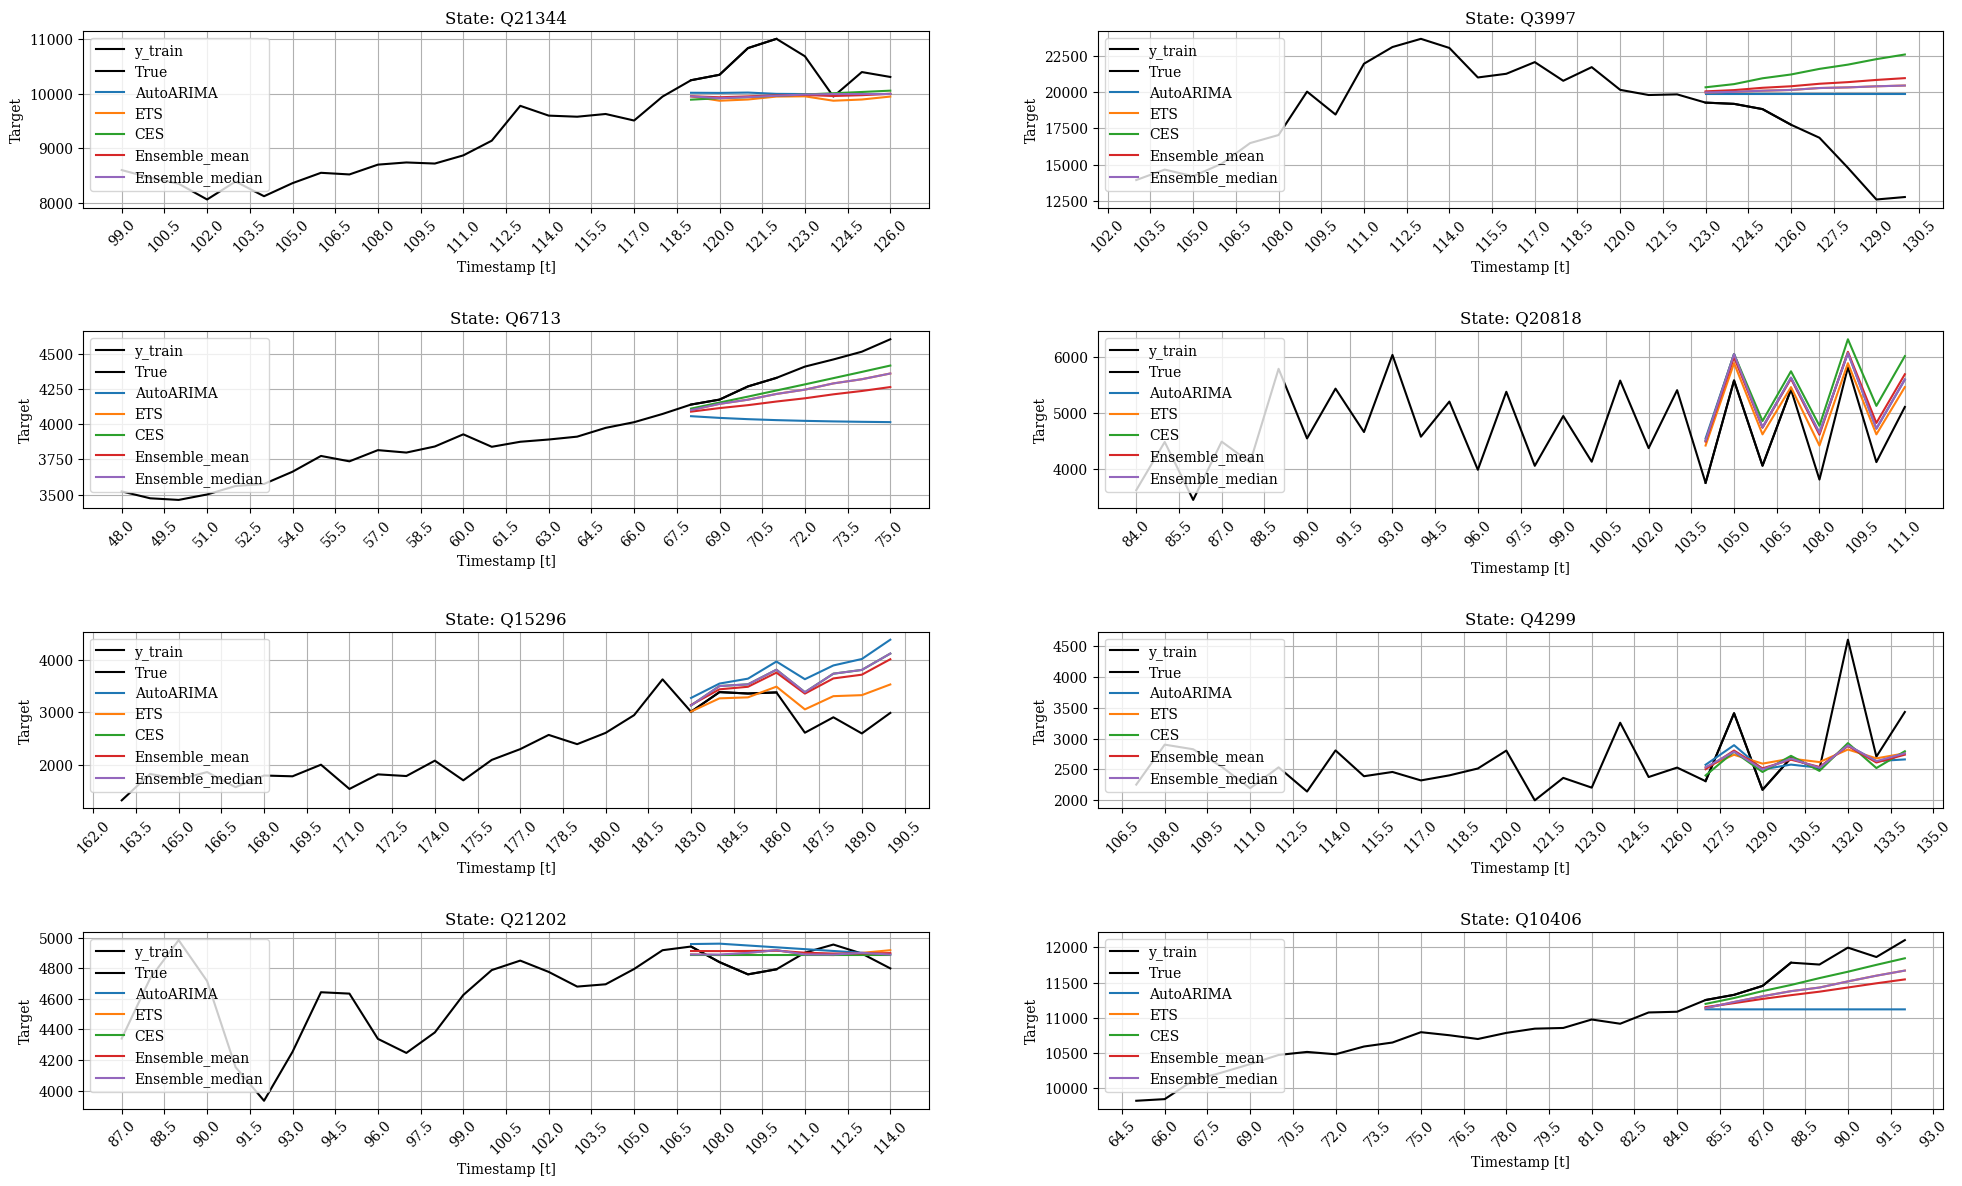

In [100]:
# Get trarin dataframe:
df_train_quarterly = get_train_df('Quarterly')

# Plot a random sample of 8 series:
plot_grid(df_train_quarterly.groupby('unique_id').tail(3*8),
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=quarterly_df_forecast)

In [129]:
#Evaluate models metrics:
df_fore_hformat_quarterly = pd.read_csv('quarterly_df_forecast.csv')

df_fore_hformat_quarterly = df_fore_hformat_quarterly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_quarterly['ds'] = df_fore_hformat_quarterly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_quarterly: np.arange(1, len(df_fore_hformat_quarterly) + 1))
df_fore_hformat_quarterly = pd.melt(df_fore_hformat_quarterly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_quarterly = pd.pivot(df_fore_hformat_quarterly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_quarterly['model'] == 'Ensemble_median'
df_fore_hformat_quarterly_ens = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_ens = df_fore_hformat_quarterly_ens.set_index(df_fore_hformat_quarterly_ens['id'])
df_fore_hformat_quarterly_ens = df_fore_hformat_quarterly_ens.drop(['id', 'model'], axis=1)

q_metrics_ens = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_quarterly['model'] == 'AutoARIMA'
df_fore_hformat_quarterly_AutoARIMA = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_AutoARIMA = df_fore_hformat_quarterly_AutoARIMA.set_index(df_fore_hformat_quarterly_AutoARIMA['id'])
df_fore_hformat_quarterly_AutoARIMA = df_fore_hformat_quarterly_AutoARIMA.drop(['id', 'model'], axis=1)

q_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_quarterly['model'] == 'ETS'
df_fore_hformat_quarterly_ETS = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_ETS = df_fore_hformat_quarterly_ETS.set_index(df_fore_hformat_quarterly_ETS['id'])
df_fore_hformat_quarterly_ETS = df_fore_hformat_quarterly_ETS.drop(['id', 'model'], axis=1)

q_metrics_ETS = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_quarterly['model'] == 'CES'
df_fore_hformat_quarterly_CES = df_fore_hformat_quarterly[df_mask]

df_fore_hformat_quarterly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_quarterly_CES = df_fore_hformat_quarterly_CES.set_index(df_fore_hformat_quarterly_CES['id'])
df_fore_hformat_quarterly_CES = df_fore_hformat_quarterly_CES.drop(['id', 'model'], axis=1)

q_metrics_CES = M4Evaluation.evaluate('data2', 'Quarterly', df_fore_hformat_quarterly_CES.sort_values('id').values)

# Total metrics:
metrics_quarterly = [q_metrics_ens, q_metrics_AutoARIMA, q_metrics_ETS, q_metrics_CES]  # List of dataframes
total_metrics_quarterly = pd.concat(metrics_quarterly)
total_metrics_quarterly['model'] = ['Ensemble', 'AutoARIMA', 'ETS', 'CES']
total_metrics_quarterly

,SMAPE,MASE,OWA,model
Quarterly,10.074105,1.149405,0.876501,Ensemble
Quarterly,11.565041,1.398230,1.034920,AutoARIMA
Quarterly,10.367345,1.171166,0.897750,ETS
Quarterly,10.479131,1.183724,0.907404,CES


### Yearly time series forecast:

In [ ]:
# Create forecasts:
yearly_df_forecast = generate_forecast('data', 'M4', 'Yearly')

In [78]:
# Create Ensemble models:
yearly_df_forecast['Ensemble_mean'] = (yearly_df_forecast.AutoARIMA + yearly_df_forecast.ETS + yearly_df_forecast.CES) / 3
yearly_df_forecast['Ensemble_median'] = yearly_df_forecast[['AutoARIMA', 'ETS', 'CES']].median(axis=1)

# Export Pandas DataFrame to CSV:
yearly_df_forecast.to_csv('yearly_df_forecast.csv')

# Print dataframe:
yearly_df_forecast

,Unnamed: 0,unique_id,ds,y,AutoARIMA,ETS,CES,Ensemble_mean,Ensemble_median
0,0,Y1,32,7290.2,7094.7534,7261.1,7410.2900,7255.381133,7261.1000
1,1,Y1,33,7392.6,6992.0390,7261.1,7467.2593,7240.132767,7261.1000
2,2,Y1,34,7527.6,6928.6160,7261.1,7547.5386,7245.751533,7261.1000
3,3,Y1,35,7594.8,6889.4540,7261.1,7610.1370,7253.563667,7261.1000
4,4,Y1,36,7720.7,6865.2730,7261.1,7688.2440,7271.539000,7261.1000
...,...,...,...,...,...,...,...,...,...
137995,137995,Y9999,26,10570.0,10630.6560,9517.0,10989.1690,10378.941667,10630.6560
137996,137996,Y9999,27,11080.0,11187.4840,9517.0,11592.6490,10765.711000,11187.4840
137997,137997,Y9999,28,12274.0,11744.3125,9517.0,12716.7740,11326.028833,11744.3125
137998,137998,Y9999,29,13128.0,12301.1410,9517.0,13512.6830,11776.941333,12301.1410


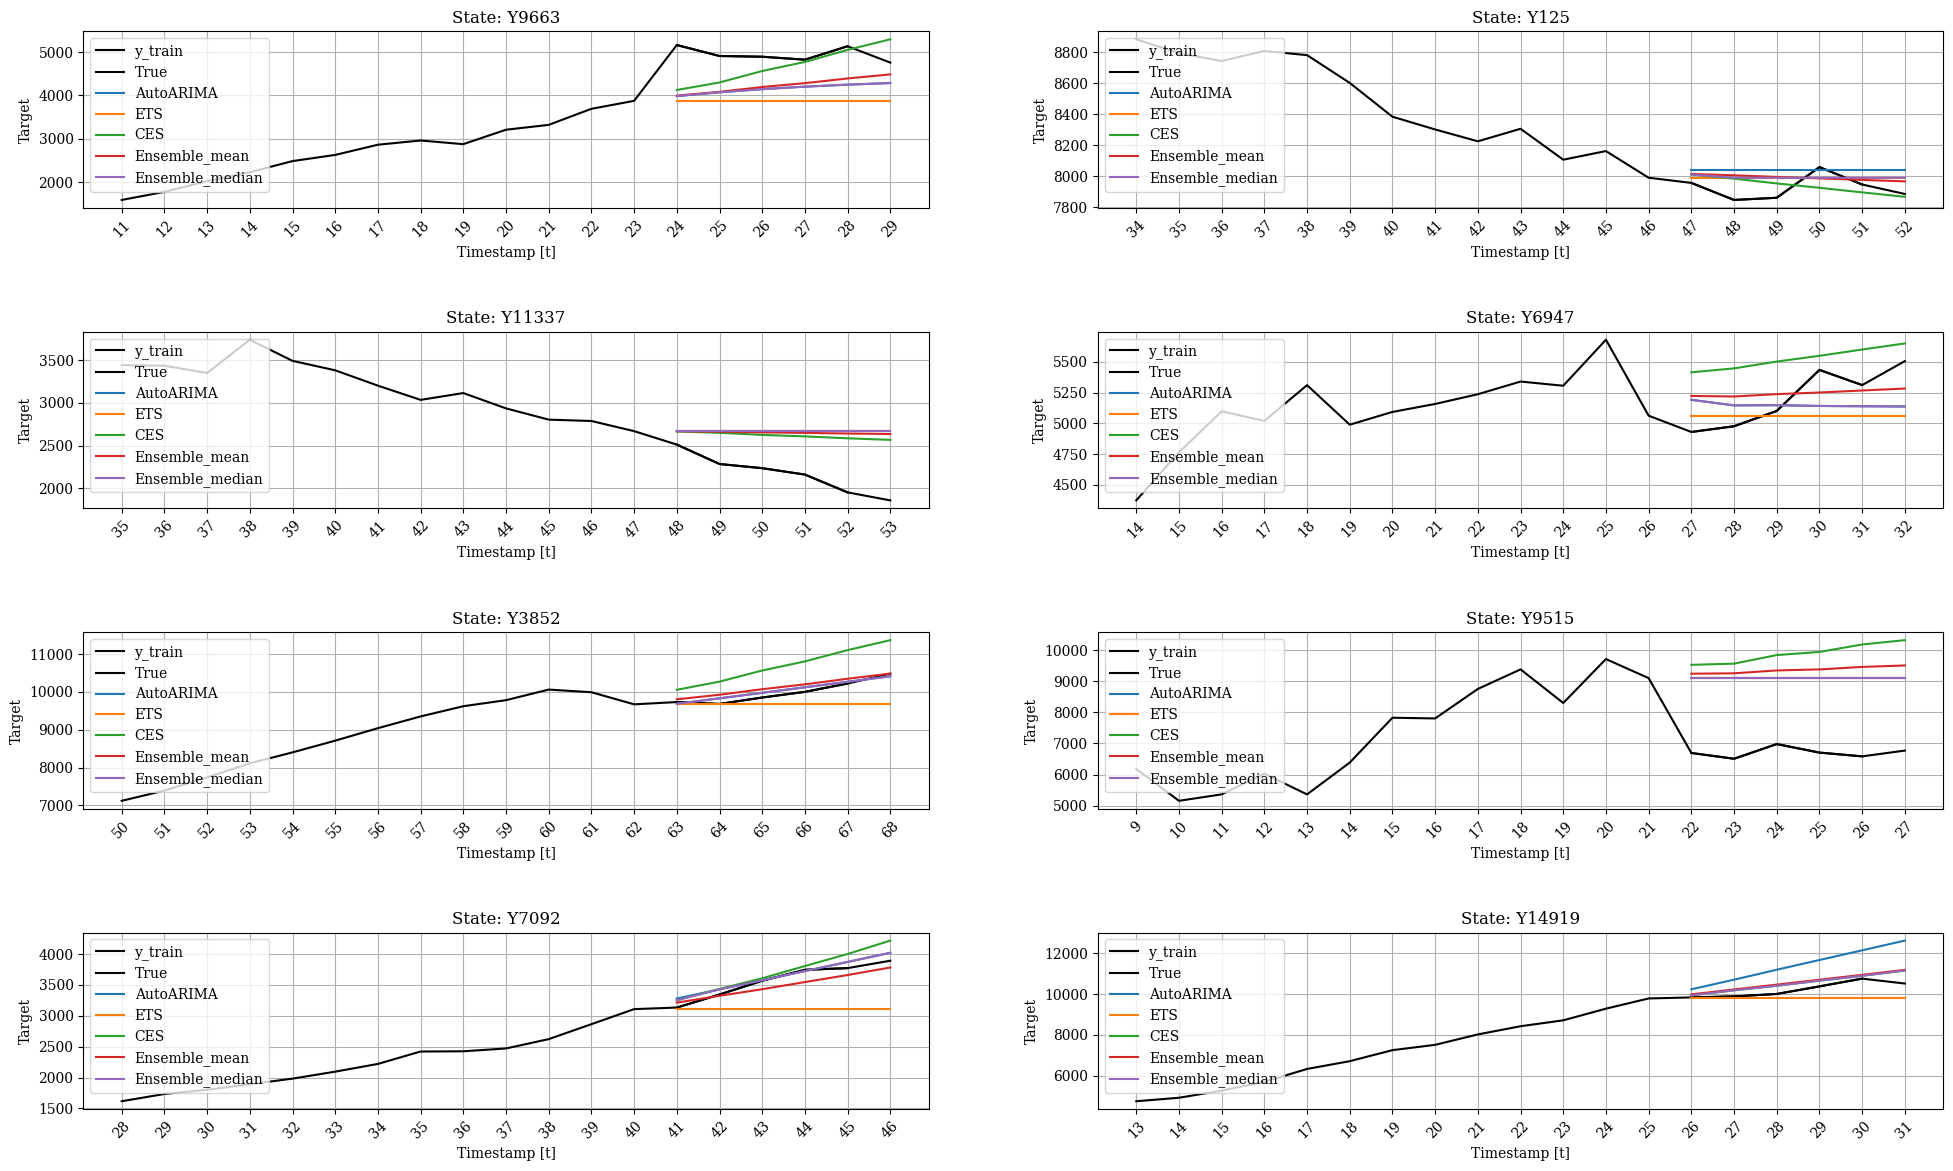

In [101]:
# Get trarin dataframe:
df_train_yearly = get_train_df('Yearly')

# Plot a random sample of 8 series:
plot_grid(df_train_yearly.groupby('unique_id').tail(3*6), 
          model_cols=['AutoARIMA', 'ETS', 'CES', 'Ensemble_mean', 'Ensemble_median'], 
          df_test=yearly_df_forecast)

In [130]:
#Evaluate models metrics:
df_fore_hformat_yearly = pd.read_csv('yearly_df_forecast.csv')

df_fore_hformat_yearly = df_fore_hformat_yearly.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df_fore_hformat_yearly['ds'] = df_fore_hformat_yearly.groupby('unique_id')['ds'].transform(lambda df_fore_hformat_yearly: np.arange(1, len(df_fore_hformat_yearly) + 1))
df_fore_hformat_yearly = pd.melt(df_fore_hformat_yearly, id_vars=['unique_id', 'ds'], var_name='model')
df_fore_hformat_yearly = pd.pivot(df_fore_hformat_yearly, index=['unique_id', 'model'], columns='ds', values='value').reset_index()

#Ensemble model:
df_mask=df_fore_hformat_yearly['model'] == 'Ensemble_median'
df_fore_hformat_yearly_ens = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_ens.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_ens = df_fore_hformat_yearly_ens.set_index(df_fore_hformat_yearly_ens['id'])
df_fore_hformat_yearly_ens = df_fore_hformat_yearly_ens.drop(['id', 'model'], axis=1)

y_metrics_ens = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_ens.sort_values('id').values)

#AutoARIMA
df_mask=df_fore_hformat_yearly['model'] == 'AutoARIMA'
df_fore_hformat_yearly_AutoARIMA = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_AutoARIMA.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_AutoARIMA = df_fore_hformat_yearly_AutoARIMA.set_index(df_fore_hformat_yearly_AutoARIMA['id'])
df_fore_hformat_yearly_AutoARIMA = df_fore_hformat_yearly_AutoARIMA.drop(['id', 'model'], axis=1)

y_metrics_AutoARIMA = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_AutoARIMA.sort_values('id').values)

#ETS
df_mask=df_fore_hformat_yearly['model'] == 'ETS'
df_fore_hformat_yearly_ETS = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_ETS.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_ETS = df_fore_hformat_yearly_ETS.set_index(df_fore_hformat_yearly_ETS['id'])
df_fore_hformat_yearly_ETS = df_fore_hformat_yearly_ETS.drop(['id', 'model'], axis=1)

y_metrics_ETS = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_ETS.sort_values('id').values)

#CES
df_mask=df_fore_hformat_yearly['model'] == 'CES'
df_fore_hformat_yearly_CES = df_fore_hformat_yearly[df_mask]

df_fore_hformat_yearly_CES.rename(columns={'unique_id': 'id'}, inplace=True)
df_fore_hformat_yearly_CES = df_fore_hformat_yearly_CES.set_index(df_fore_hformat_yearly_CES['id'])
df_fore_hformat_yearly_CES = df_fore_hformat_yearly_CES.drop(['id', 'model'], axis=1)

y_metrics_CES = M4Evaluation.evaluate('data2', 'Yearly', df_fore_hformat_yearly_CES.sort_values('id').values)

# Total metrics:
metrics_yearly = [y_metrics_ens, y_metrics_AutoARIMA, y_metrics_ETS, y_metrics_CES]  # List of dataframes
total_metrics_yearly = pd.concat(metrics_yearly)
total_metrics_yearly['model'] = ['Ensemble', 'AutoARIMA', 'ETS', 'CES']
total_metrics_yearly

,SMAPE,MASE,OWA,model
Yearly,14.525360,3.339814,0.864583,Ensemble
Yearly,16.568475,3.832562,0.989085,AutoARIMA
Yearly,16.342174,3.974360,1.000000,ETS
Yearly,14.460315,3.416768,0.872275,CES


### Total metrics:

In [176]:
metrics_all_models = [total_metrics_hourly, 
                                total_metrics_daily, 
                                total_metrics_weekly, 
                                total_metrics_monthly, 
                                total_metrics_quarterly,
                                total_metrics_yearly]  # List of dataframes
total_metrics_all_models = pd.concat(metrics_all_models)

total_metrics_all_models.reset_index(inplace=True, names='frequency')
total_metrics_all_models.set_index(total_metrics_all_models['model'], inplace=True)
total_metrics_all_models.drop(columns='model', inplace=True)

total_metrics_all_models.sort_index()

,frequency,SMAPE,MASE,OWA
model,,,,
AutoARIMA,Hourly,13.785071,1.060768,0.596394
AutoARIMA,Yearly,16.568475,3.832562,0.989085
AutoARIMA,Quarterly,11.565041,1.398230,1.034920
AutoARIMA,Daily,3.147886,3.313655,1.022225
AutoARIMA,Monthly,14.571859,1.083398,1.014449
AutoARIMA,Weekly,7.918108,2.674030,0.913559
CES,Weekly,8.116045,2.352535,0.866483
CES,Quarterly,10.479131,1.183724,0.907404
CES,Monthly,13.135264,0.935648,0.895186


### Conclusions

The Ensemble model created in a few lines of code outperform almost all the metrics of AutoARIMA, ETS and CES forecasts by separeted. 

In [175]:
conditions = [
    (total_metrics_all_models['frequency'] == 'Hourly'),
    (total_metrics_all_models['frequency'] == 'Daily'),
    (total_metrics_all_models['frequency'] == 'Weekly'),
    (total_metrics_all_models['frequency'] == 'Monthly'),
    (total_metrics_all_models['frequency'] == 'Quarterly'),
    (total_metrics_all_models['frequency'] == 'Yearly')
]

weights = [0.00414, 0.04227, 0.00359, 0.48, 0.24, 0.23]

total_metrics_all_models['weights'] = np.select(conditions, weights)
total_metrics_all_models['smape_weighted'] = total_metrics_all_models['SMAPE'] * total_metrics_all_models['weights'] 
total_metrics_all_models['mase_weighted'] = total_metrics_all_models['MASE'] * total_metrics_all_models['weights']
total_metrics_all_models['owa_weighted'] = total_metrics_all_models['OWA'] * total_metrics_all_models['weights']

total_metrics_all_models.groupby('model')[['smape_weighted', 'mase_weighted', 'owa_weighted']].sum()


,smape_weighted,mase_weighted,owa_weighted
model,,,
AutoARIMA,13.799409,1.891155,1.011764
CES,12.388720,1.672762,0.897565
ETS,12.874474,1.807509,0.931799
Ensemble,12.106087,1.633640,0.876102
